In [1]:
%matplotlib inline


# Compute source space connectivity and visualize it using a circular graph

This example computes the all-to-all connectivity between 68 regions in
source space based on dSPM inverse solutions and a FreeSurfer cortical
parcellation. The connectivity is visualized using a circular graph which
is ordered based on the locations of the regions in the axial plane.


In [1]:
# Authors: Martin Luessi <mluessi@nmr.mgh.harvard.edu>
#          Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Nicolas P. Rougier (graph code borrowed from his matplotlib gallery)
#
# License: BSD (3-clause)

import numpy as np
import os.path as op
import os
import matplotlib.pyplot as plt
from langouEEG import *

import mne
import pickle
from mne.datasets import sample
from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.connectivity import spectral_connectivity
from mne.viz import circular_layout, plot_connectivity_circle
import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage
from mne.datasets import sample
from mne.minimum_norm import make_inverse_operator, apply_inverse
from mne.minimum_norm import write_inverse_operator

import os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa
import mne

sample_data_folder = mne.datasets.sample.data_path()
dataRoot = "/data/home/viscent/Light"
# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
isMale = True
result_dir = op.join(dataRoot,'result','male' if isMale else 'female')
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')
print(__doc__)

0 files missing from root.txt in /data/home/viscent/mne_data/MNE-fsaverage-data
0 files missing from bem.txt in /data/home/viscent/mne_data/MNE-fsaverage-data/fsaverage
Automatically created module for IPython interactive environment


In [3]:
montage_dir = os.path.join(os.path.dirname(mne.__file__),
                           'channels', 'data', 'montages')
print('\nBUILT-IN MONTAGE FILES')
print('======================')
print(montage_dir)


BUILT-IN MONTAGE FILES
/data/home/viscent/.conda/envs/mne/lib/python3.9/site-packages/mne/channels/data/montages


In [3]:
epochs_4F = []
epochs_RF = []
for subject_name in range(1,21):
    if not (isMale ^ (subject_name in [7,8,11,17])):
        continue
    if subject_name<10:
        subject_name='S0'+str(subject_name)
    else:
        subject_name='S'+str(subject_name)
    with open(dataRoot+'/clean_data/'+subject_name+'_clean.lgeeg','rb') as f:
        raw=pickle.load(f)
    raw.set_channel_types({'Trigger':'stim','VEO':'eog'})
    raw.set_eeg_reference(projection=True)
    events, event_dict=extractEvents(raw)
    picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                        exclude='bads')
    epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
    epochs_4F.append(epoch_4F)
    epochs_RF.append(epoch_RF)
epochs_4F = mne.concatenate_epochs(epochs_4F)
epochs_RF = mne.concatenate_epochs(epochs_RF)

space dimension = 1)
1 projection items activated
Loading data for 6 events and 30001 original time points ...
<ipython-input-3-a08c027b5e98>:12: RuntimeWarning: The unit for channel(s) Trigger has changed from V to NA.
  raw.set_channel_types({'Trigger':'stim','VEO':'eog'})
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 13501 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 13501 original time points ...
0 bad epochs dropped
Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method

## Load our data

First we'll load the data we'll use in connectivity estimation. We'll use
the sample MEG data provided with MNE.



In [4]:
subject_name='S15'
with open(dataRoot+'/clean_data/'+subject_name+'_clean.lgeeg','rb') as f:
    raw=pickle.load(f)
raw.set_channel_types({'Trigger':'stim','VEO':'eog'})
raw.set_eeg_reference(projection=True)
events, event_dict=extractEvents(raw)
if not op.exists(os.path.join(dataRoot,'fwd_solutions',subject_name+'_fwd.lgeeg')):
    fwd = mne.make_forward_solution(raw.info, trans=trans, src=src,
                                    bem=bem, eeg=True, mindist=5.0, n_jobs=1)
    print(fwd)
    mne.write_forward_solution(os.path.join(dataRoot,'fwd_solutions',subject_name+'_fwd.lgeeg'),fwd,overwrite=True)
else:
    fwd = mne.read_forward_solution(os.path.join(dataRoot,'fwd_solutions',subject_name+'_fwd.lgeeg'))


Adding average EEG reference projection.
1 projection items deactivated
Average reference projection was added, but has not been applied yet. Use the apply_proj method to apply it.
file info:
<Info | 11 non-empty values
 bads: 1 items (Trigger)
 ch_names: FP1, FPZ, FP2, AF3, AF4, F7, F5, F3, F1, FZ, F2, F4, F6, F8, ...
 chs: 64 EEG, 1 EOG, 1 STIM
 custom_ref_applied: False
 dig: 66 items (66 EEG)
 highpass: 0.1 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 66
 projs: Average EEG reference: off
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>
channel names:
['FP1', 'FPZ', 'FP2', 'AF3', 'AF4', 'F7', 'F5', 'F3', 'F1', 'FZ', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCZ', 'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'CZ', 'C2', 'C4', 'C6', 'T8', 'M1', 'TP7', 'CP5', 'CP3', 'CP1', 'CPZ', 'CP2', 'CP4', 'CP6', 'TP8', 'M2', 'P7', 'P5', 'P3', 'P1', 'PZ', 'P2', 'P4', 'P6', 'P8', 'PO7', 'PO5', 'PO3', 'POZ', 'PO4', 'PO6', 'PO8', 'CB1', 'O1', 'OZ', 'O2', 'CB2', 'VEO', 'Trig

In [5]:
data_path = sample.data_path()
# subjects_dir = data_path + '/subjects'
fname_inv = os.path.join(dataRoot,'inv_operators',subject_name+'_inv.lgeeg')
# subject = 'sample'
# fname_raw = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'
# fname_event = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw-eve.fif'


# Pick MEG channels
picks = mne.pick_types(raw.info, meg=False, eeg=True, stim=False, eog=True,
                       exclude='bads')

epoch_RR,epoch_RF,epoch_4R,epoch_4F = extractEpochs(raw,events,picks)
# evoked_4F = epoch_4F.average().pick('eeg')
# Define epochs for left-auditory condition
# event_id, tmin, tmax = 1, -0.2, 0.5
# epochs = mne.Epochs(raw, events, event_id, tmin, tmax, picks=picks,
                    # baseline=(None, 0), reject=dict(mag=4e-12, grad=4000e-13,
                    #                                 eog=150e-6))


noise_cov = mne.compute_covariance(
    epoch_RR, tmax=80., method=['shrunk', 'empirical'], rank=None, verbose=True)
if not os.path.exists(fname_inv):  
    inverse_operator = make_inverse_operator(
        epochs_4F.info, fwd, noise_cov, loose=0.2, depth=0.8)
    write_inverse_operator(os.path.join(dataRoot,'inv_operators',subject_name+'_inv.lgeeg'),inverse_operator)
else:   
# Load data
    inverse_operator = read_inverse_operator(fname_inv)
# raw = mne.io.read_raw_fif(fname_raw)
# events = mne.read_events(fname_event)

Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 13501 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 30001 original time points ...
1 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading data for 5 events and 30001 original time points ...
0 bad epochs dropped
Not setting metadata
Not setting metadata
5 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Loading da

## Compute inverse solutions and their connectivity

Next, we need to compute the inverse solution for this data. This will return
the sources / source activity that we'll use in computing connectivity. We'll
compute the connectivity in the alpha band of these sources. We can specify
particular frequencies to include in the connectivity with the ``fmin`` and
``fmax`` flags. Notice from the status messages how mne-python:

1. reads an epoch from the raw file
2. applies SSP and baseline correction
3. computes the inverse to obtain a source estimate
4. averages the source estimate to obtain a time series for each label
5. includes the label time series in the connectivity computation
6. moves to the next epoch.

This behaviour is because we are using generators. Since we only need to
operate on the data one epoch at a time, using a generator allows us to
compute connectivity in a computationally efficient manner where the amount
of memory (RAM) needed is independent from the number of epochs.



In [6]:
# Compute inverse solution and for each epoch. By using "return_generator=True"
# stcs will be a generator object instead of a list.

snr = 1.0  # use lower SNR for single epochs
lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(epochs_4F, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)

# Get labels for FreeSurfer 'aparc' cortical parcellation with 34 labels/hemi
labels = mne.read_labels_from_annot('fsaverage', parc='aparc',
                                    subjects_dir=subjects_dir)[:68]
label_colors = [label.color for label in labels]

# Average the source estimates within each label using sign-flips to reduce
# signal cancellations, also here we return a generator
src = inverse_operator['src']
label_ts = mne.extract_label_time_course(
    stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=True)
fmin = 8.
fmax = 13.
sfreq = raw.info['sfreq']  # the sampling frequency
con_methods = ['pli', 'wpli2_debiased', 'ciplv']
if not op.exists(op.join(result_dir,'cons','40_con.lgeeg')):
    con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
    with open(op.join(result_dir,'cons','40_con.lgeeg'),'wb') as f:
        pickle.dump(con,f)
else:
    with open(op.join(result_dir,'cons','40_con.lgeeg'),'rb') as f:
        con = pickle.load(f)
con_res_40 = dict()
for method, c in zip(con_methods, con):
    con_res_40[method] = c[:, :, 0]

lambda2 = 1.0 / snr ** 2
method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)
stcs = apply_inverse_epochs(epochs_RF, inverse_operator, lambda2, method,
                            pick_ori="normal", return_generator=True)
label_ts = mne.extract_label_time_course(
    stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=True)
if not op.exists(op.join(result_dir,'cons','rand_con.lgeeg')):
    con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
        label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
        fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
    with open(op.join(result_dir,'cons','rand_con.lgeeg'),'wb') as f:
        pickle.dump(con,f)
else:
    with open(op.join(result_dir,'cons','rand_con.lgeeg'),'rb') as f:
        con = pickle.load(f)
# con is a 3D array, get the connectivity for the first (and only) freq. band
# for each method
con_res_rand = dict()
for method, c in zip(con_methods, con):
    con_res_rand[method] = c[:, :, 0]


Reading labels from parcellation...
   read 35 labels from /data/home/viscent/mne_data/MNE-fsaverage-data/fsaverage/label/lh.aparc.annot
   read 34 labels from /data/home/viscent/mne_data/MNE-fsaverage-data/fsaverage/label/rh.aparc.annot


In [24]:
cons_40 = []
cons_rand = []
act_40 = []
act_rand = []

for i in range(len(epochs_4F)):
    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)  
    if not op.exists(op.join(result_dir,'stc','40_stc'+str(i)+'.lgeeg')):
        stcs = apply_inverse_epochs(epochs_4F[i], inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=False)
        with open(op.join(result_dir,'stc','40_stc'+str(i)+'.lgeeg'),'wb') as f:
            pickle.dump(stcs,f)
    else:
        with open(op.join(result_dir,'stc','40_stc'+str(i)+'.lgeeg'),'rb') as f:
            stcs = pickle.load(f)
    label_ts = mne.extract_label_time_course(
    stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
    _, time_max = stcs[0].get_peak(hemi='lh')
    act_40.append(label_ts[0][:,round(time_max)])
    fmin = 8.
    fmax = 13.
    sfreq = raw.info['sfreq']  # the sampling frequency
    con_methods = ['pli', 'wpli2_debiased', 'ciplv']
    if op.exists(op.join(result_dir,'cons','40_con'+str(i)+'.lgeeg')):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        with open(op.join(result_dir,'cons','40_con'+str(i)+'.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        with open(op.join(result_dir,'cons','40_con'+str(i)+'.lgeeg'),'rb') as f:
            con = pickle.load(f)
    cons_40.append(con)
for i in range(len(epochs_RF)):
    snr = 1.0  # use lower SNR for single epochs
    lambda2 = 1.0 / snr ** 2
    method = "dSPM"  # use dSPM method (could also be MNE or sLORETA)  
    if not op.exists(op.join(result_dir,'stc','rand_stc'+str(i)+'.lgeeg')):
        stcs = apply_inverse_epochs(epochs_RF[i], inverse_operator, lambda2, method,
                                pick_ori="normal", return_generator=False)
        with open(op.join(result_dir,'stc','rand_stc'+str(i)+'.lgeeg'),'wb') as f:
            pickle.dump(stcs,f)
    else:
        with open(op.join(result_dir,'stc','rand_stc'+str(i)+'.lgeeg'),'rb') as f:
            stcs = pickle.load(f)
    label_ts = mne.extract_label_time_course(
    stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
    _, time_max = stcs[0].get_peak(hemi='lh')
    act_rand.append(label_ts[0][:,round(time_max)])
    fmin = 8.
    fmax = 13.
    sfreq = raw.info['sfreq']  # the sampling frequency
    con_methods = ['pli', 'wpli2_debiased', 'ciplv']
    if op.exists(op.join(result_dir,'cons','rand_con'+str(i)+'.lgeeg')):
        con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
            label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
            fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)
        with open(op.join(result_dir,'cons','rand_con'+str(i)+'.lgeeg'),'wb') as f:
            pickle.dump(con,f)
    else:
        with open(op.join(result_dir,'cons','rand_con'+str(i)+'.lgeeg'),'rb') as f:
            con = pickle.load(f)
    cons_rand.append(con)
cons_40=np.array(cons_40).squeeze()
cons_rand=np.array(cons_rand).squeeze()
act_40=np.array(act_40)
act_rand=np.array(act_rand)

ores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI, Debiased WPLI Square, ciPLV
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Extracting time courses for 68 labels (mode: mean_flip)
Connectivity computation...
only using indices for lower-triangular matrix
    computing connectivity for 2278 connections
    using t=0.000s..27.000s for estimation (13501 points)
    frequencies: 8.0Hz..13.0Hz (135 points)
    connectivity scores will be averaged for each band
    Using multitaper spectrum estimation with 7 DPSS windows
    the following metrics will be computed: PLI, Debiased WPLI Square, ciPLV
    computing connectivity for epoch 1
    assembling connectivity matrix
[Connectivity computation done]
Extracting time courses for 68 labels (mode: mean_flip)
Connectivity computation...
only using indices for lower-triangular matrix
    compu

In [8]:
# stcs = apply_inverse_epochs(epochs_4F[0], inverse_operator, lambda2, method,
#                         pick_ori="normal", return_generator=False)
# label_ts = mne.extract_label_time_course(
# stcs, labels,  src,allow_empty=False, mode='mean_flip', return_generator=False)
# _, time_max = stcs[0].get_peak(hemi='lh')
# act_40.append(label_ts[0][:,round(time_max)])
# fmin = 8.
# fmax = 13.
# sfreq = raw.info['sfreq']  # the sampling frequency
# con_methods = ['pli', 'wpli2_debiased', 'ciplv']
# con, freqs, times, n_epochs, n_tapers = spectral_connectivity(
#     label_ts, method=con_methods, mode='multitaper', sfreq=sfreq, fmin=fmin,
#     fmax=fmax, faverage=True, mt_adaptive=True, n_jobs=1)

## Make a connectivity plot

Now, we visualize this connectivity using a circular graph layout.



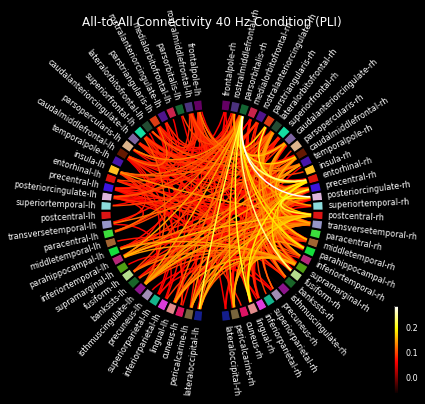

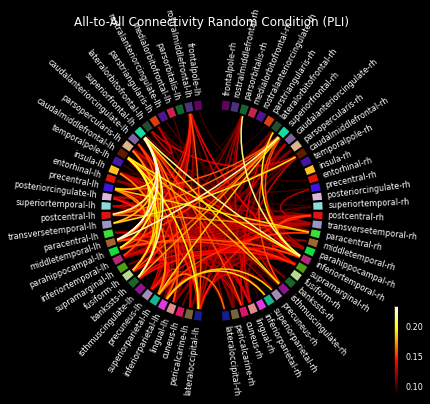

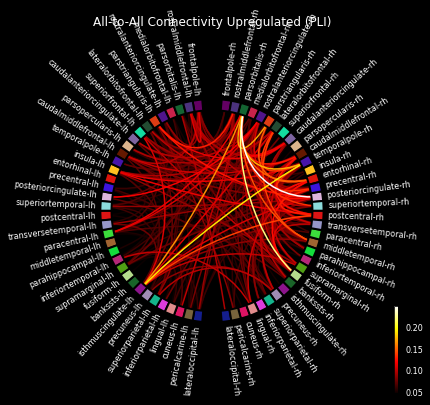

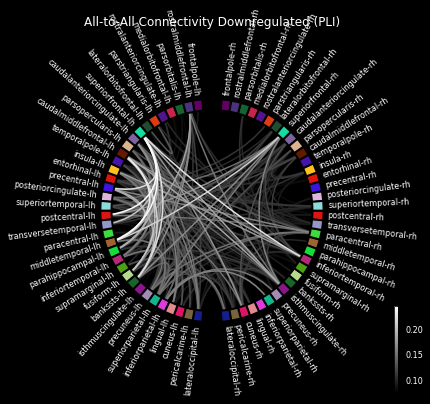

In [9]:
# First, we reorder the labels based on their location in the left hemi
label_names = [label.name for label in labels]

lh_labels = [name for name in label_names if name.endswith('lh')]

# Get the y-location of the label
label_ypos = list()
for name in lh_labels:
    idx = label_names.index(name)
    ypos = np.mean(labels[idx].pos[:, 1])
    label_ypos.append(ypos)

# Reorder the labels based on their location
lh_labels = [label for (yp, label) in sorted(zip(label_ypos, lh_labels))]

# For the right hemi
rh_labels = [label[:-2] + 'rh' for label in lh_labels]

# Save the plot order and create a circular layout
node_order = list()
node_order.extend(lh_labels[::-1])  # reverse the order
node_order.extend(rh_labels)
# node_order = node_order[:69]

node_angles = circular_layout(label_names, node_order, start_pos=90,
                              group_boundaries=[0, len(label_names) / 2])

# Plot the graph using node colors from the FreeSurfer parcellation. We only
# show the 300 strongest connections.
fig,ax=plot_connectivity_circle(con_res_40['wpli2_debiased'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, 
                         title='All-to-All Connectivity 40 Hz '
                               'Condition (PLI)')
fig.savefig(op.join(result_dir,'40-connectivity.png'),facecolor='black')
fig,ax=plot_connectivity_circle(con_res_rand['wpli2_debiased'], label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, 
                         title='All-to-All Connectivity Random '
                               'Condition (PLI)')
fig.savefig(op.join(result_dir,'rand-connectivity.png'),facecolor='black')
dcon_res = con_res_40['wpli2_debiased'] - con_res_rand['wpli2_debiased']
fig,ax=plot_connectivity_circle(np.where(dcon_res<0,0,dcon_res), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='hot', 
                         title='All-to-All Connectivity Upregulated '
                               '(PLI)')
fig.savefig(op.join(result_dir,'up-connectivity.png'),facecolor='black')
fig,ax=plot_connectivity_circle(np.where(dcon_res>0,0,-1*dcon_res), label_names, n_lines=300,
                         node_angles=node_angles, node_colors=label_colors, colormap='gray',
                         title='All-to-All Connectivity Downregulated '
                               '(PLI)')
fig.savefig(op.join(result_dir,'down-connectivity.png'),facecolor='black')


In [25]:
for i in range(len(epochs_4F)):
    pd_40=pd.DataFrame(cons_40[i][1].squeeze())
    pd_40.columns = label_names
    pd_40.index = label_names
    pd_40.to_excel(op.join(result_dir,'con_stat','40_conn'+str(i)+'.xlsx'))
for i in range(len(epochs_RF)):
    pd_rand=pd.DataFrame(cons_rand[i][1].squeeze())
    pd_rand.columns = label_names
    pd_rand.index = label_names
    pd_rand.to_excel(op.join(result_dir,'con_stat','rand_conn'+str(i)+'.xlsx'))


In [23]:
cons_rand[i].shape

(68, 68)

In [26]:
pd_40=pd.DataFrame(act_40)
pd_40.columns = label_names
pd_40.to_excel(op.join(result_dir,'40_activation.xlsx'))
pd_rand=pd.DataFrame(act_rand)
pd_rand.columns = label_names
pd_rand.to_excel(op.join(result_dir,'rand_activation.xlsx'))


In [ ]:
if not op.exists(op.join(result_dir,'stc','rand_stc.lgeeg')):
    stcs_rand = apply_inverse_epochs(epochs_RF, inverse_operator, lambda2, 'dSPM',
                            pick_ori="normal")
    avg_stc_rand = np.mean(stcs_rand)
    with open(op.join(result_dir,'stc','rand_stc.lgeeg'),'wb') as f:
        pickle.dump(avg_stc_rand,f)
    del stcs_rand
else:
    with open(op.join(result_dir,'stc','rand_stc.lgeeg'),'rb') as f:
        avg_stc_rand = pickle.load(f)           
if not op.exists(op.join(result_dir,'stc','rand_con.lgeeg')):
    stcs_40 = apply_inverse_epochs(epochs_4F, inverse_operator, lambda2, 'dSPM',
                            pick_ori="normal")
    avg_stc_40 = np.mean(stcs_40)
    with open(op.join(result_dir,'stc','40_stc.lgeeg'),'wb') as f:
        pickle.dump(avg_stc_40,f)
    del stcs_40
else:
    with open(op.join(result_dir,'stc','40_stc.lgeeg'),'rb') as f:
        avg_stc_40 = pickle.load(f) 
                                   


In [ ]:
stc = avg_stc_40
vertno_max, time_max = stc.get_peak(hemi='lh')
surfer_kwargs = dict(
    hemi='lh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 1, 2]), views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800),backend ='matplotlib', smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.savefig(op.join(result_dir,'activation_40_lh.png'))
vertno_max, time_max = stc.get_peak(hemi='rh')
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 1, 2]), views='dor',
    initial_time=10, time_unit='s', size=(800, 800),backend ='matplotlib', smoothing_steps=10)
brain = avg_stc_40.plot(**surfer_kwargs)
brain.savefig(op.join(result_dir,'activation_40_rh.png'))
# brain.add_foci(vertno_max, coords_as_verts=True, hemi='lh', color='blue',
            #    scale_factor=0.6, alpha=0.5)
# brain.add_text(0.1, 0.9, 'dSPM (plus location of maximal activation)', 'title',
            #    font_size=14)


In [ ]:
stc = avg_stc_rand
vertno_max, time_max = stc.get_peak(hemi='lh')
surfer_kwargs = dict(
    hemi='lh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 1, 2]), views='dor',
    initial_time=time_max, time_unit='s', size=(800, 800),backend ='matplotlib', smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.savefig(op.join(result_dir,'activation_rand_lh.png'))
vertno_max, time_max = stc.get_peak(hemi='rh')
surfer_kwargs = dict(
    hemi='rh', subjects_dir=subjects_dir,
    clim=dict(kind='value', lims=[0, 1, 2]), views='dor',
    initial_time=10, time_unit='s', size=(800, 800),backend ='matplotlib', smoothing_steps=10)
brain = stc.plot(**surfer_kwargs)
brain.savefig(op.join(result_dir,'activation_rand_rh.png'))

In [ ]:
label_ts

## Make two connectivity plots in the same figure

We can also assign these connectivity plots to axes in a figure. Below we'll
show the connectivity plot using two different connectivity methods.



In [ ]:
# fig = plt.figure(num=None, figsize=(8, 4), facecolor='black')
# no_names = [''] * len(label_names)
# for ii, method in enumerate([con_methods]):
#     plot_connectivity_circle(con_res[method], no_names, n_lines=300,
#                              node_angles=node_angles, node_colors=label_colors,
#                              title=method, padding=0, fontsize_colorbar=6,
#                              fig=fig, subplot=(1, 3, ii + 1))

# plt.show()

## Save the figure (optional)

By default matplotlib does not save using the facecolor, even though this was
set when the figure was generated. If not set via savefig, the labels, title,
and legend will be cut off from the output png file.



In [ ]:
# fname_fig = data_path + '/MEG/sample/plot_inverse_connect.png'
# fig.savefig(fname_fig, facecolor='black')